In [1]:
DETECTION_THRESHOLD = 0.001
DATA_ROOT_PATH = '../input/vinbigdata-original-image-dataset/vinbigdata/test'
WEIGHT_PATH = '../input/2021-vin-effdet/models/last-checkpoint.bin'

In [2]:
!pip install -q ../input/nfl-lib/timm-0.1.26-py3-none-any.whl
!tar xfz ../input/nfl-lib/pkgs.tgz
# for pytorch1.6
cmd = "sed -i -e 's/ \/ / \/\/ /' timm-efficientdet-pytorch/effdet/bench.py"
!$cmd

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import sys
sys.path.insert(0, "timm-efficientdet-pytorch")
sys.path.insert(0, "omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn.functional as F
from glob import glob
import pandas as pd
import gc
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
import warnings
import tensorflow as tf
from threading import Thread
import threading
from tqdm import *
from ensemble_boxes import *
import pydicom
import imagesize
print("Number of threads:",threading.active_count())

warnings.filterwarnings("ignore")

Number of threads: 4


In [4]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(SEED)

In [5]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [6]:
image_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/test"
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        dicom = pydicom.dcmread(f"{image_dir}/{image_id}.dicom")
        image = dicom.pixel_array
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image

        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image/4095
        image = image.transpose(1, 2, 0)
        
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [7]:
image_ids = glob(os.path.join('../input/vinbigdata-chest-xray-abnormalities-detection/test', "*.dicom"))
image_ids = [image_id.split('/')[-1].split('.')[0] for image_id in image_ids]
dataset = DatasetRetriever(image_ids = np.array(image_ids), transforms = get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, drop_last=False, collate_fn=collate_fn)

In [8]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d7')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 14
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    net = DetBenchEval(net, config)
    net.eval()
    return net.to(device)

net = load_net(WEIGHT_PATH)

In [9]:
def make_predictions(images, score_threshold=0.5):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, image_scales=torch.tensor([1] * images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:, :4]
            scores = det[i].detach().cpu().numpy()[:, 4]
            labels = det[i].detach().cpu().numpy()[:, 5]
            
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            
            
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(labels < 14)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            predictions.append({
                'boxes': boxes,
                'scores': scores,
                'labels': labels
            })
    return predictions

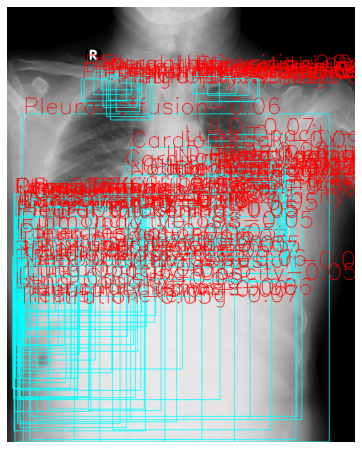

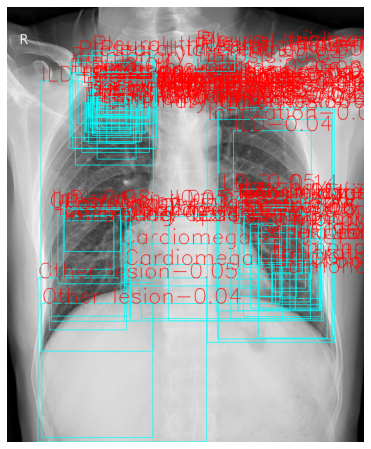

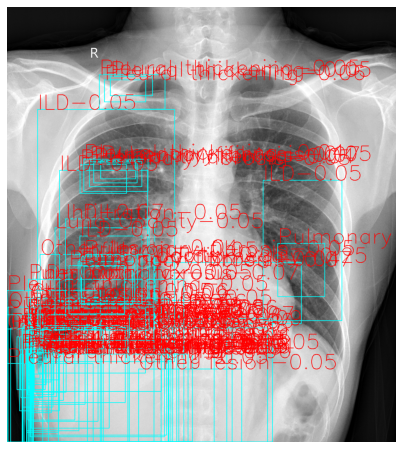

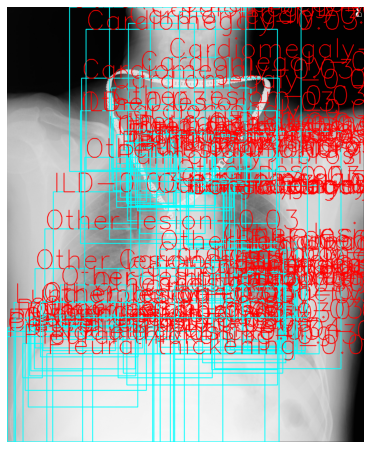

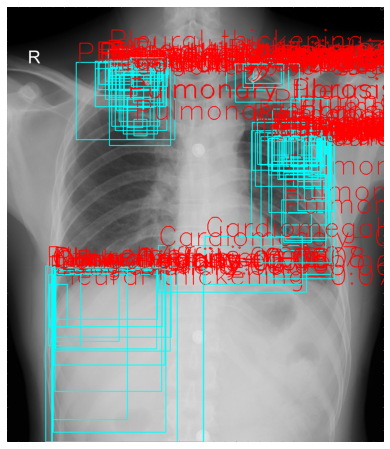

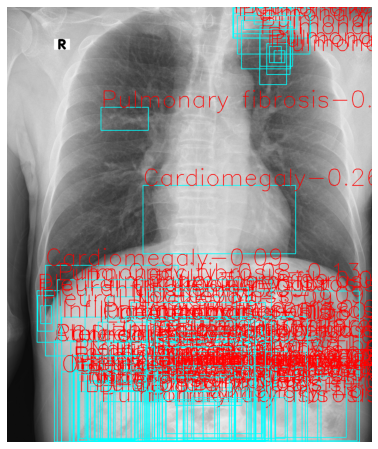

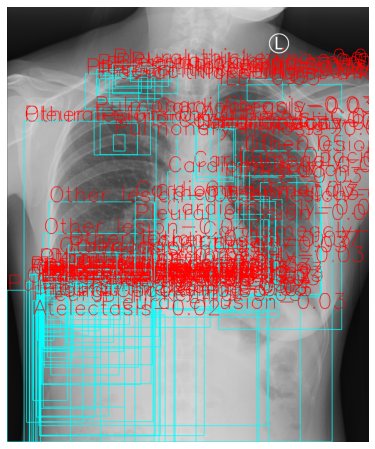

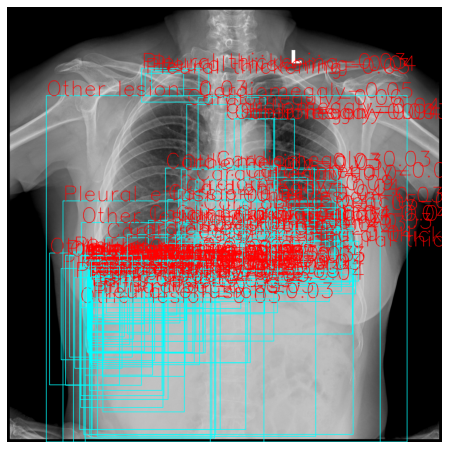

In [10]:
mapping = {0: 'Aortic enlargement', 1: 'Atelectasis', 2: 'Calcification', 3: 'Cardiomegaly', 4: 'Consolidation', 5: 'ILD',6: 'Infiltration', 7: 'Lung Opacity', 
           8: 'Nodule/Mass', 9: 'Other lesion', 10: 'Pleural effusion', 11: 'Pleural thickening',12: 'Pneumothorax', 13: 'Pulmonary fibrosis'}

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 5
thickness = 3
color = (1, 0, 0)

for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        
        if (len(prediction['scores'])>0):
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            
            w, h = imagesize.get(f'{DATA_ROOT_PATH}/{image_id}.jpg')
            image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            
            boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
            
            boxes[:, 0] = (boxes[:, 0] * w / 512)
            boxes[:, 1] = (boxes[:, 1] * h / 512)
            boxes[:, 2] = (boxes[:, 2] * w / 512)
            boxes[:, 3] = (boxes[:, 3] * h / 512)
        
            boxes = boxes.astype(np.int32)
            boxes[:, 0] = boxes[:, 0].clip(min=0, max=w-1)
            boxes[:, 2] = boxes[:, 2].clip(min=0, max=w-1)
            boxes[:, 1] = boxes[:, 1].clip(min=0, max=h-1)
            boxes[:, 3] = boxes[:, 3].clip(min=0, max=h-1)
            
            for score, box, label in zip(scores, boxes, labels):
                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 1, 1), thickness)
                cv2.putText(image, mapping[label] + "-" + str(round(score, 2)), (box[0], box[1]),
                        font, fontScale, color, thickness, cv2.LINE_AA)

            ax.set_axis_off()
            ax.imshow(image)
            plt.show()
    if j >= 1:
        break

In [11]:
def format_prediction_string(boxes, scores, labels):
    pred_strings = []
    for pred in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(int(pred[0]), pred[1], pred[2][0], pred[2][1], pred[2][2], pred[2][3]))
    result = " ".join(pred_strings)+" 14 1 0 0 1 1"
    return result

In [12]:
results = []
for images, image_ids in tqdm(data_loader):
    predictions = make_predictions(images, score_threshold=DETECTION_THRESHOLD)
    
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        w, h = imagesize.get(f'{DATA_ROOT_PATH}/{image_id}.jpg')
        
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
            
        boxes[:, 0] = (boxes[:, 0] * w / 512)
        boxes[:, 1] = (boxes[:, 1] * h / 512)
        boxes[:, 2] = (boxes[:, 2] * w / 512)
        boxes[:, 3] = (boxes[:, 3] * h / 512)
        
        boxes = boxes.astype(np.int32)
        boxes[:, 0] = boxes[:, 0].clip(min=0, max=w-1)
        boxes[:, 2] = boxes[:, 2].clip(min=0, max=w-1)
        boxes[:, 1] = boxes[:, 1].clip(min=0, max=h-1)
        boxes[:, 3] = boxes[:, 3].clip(min=0, max=h-1)
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores, labels)
        }
        results.append(result)

100%|██████████| 750/750 [35:12<00:00,  2.82s/it]


In [13]:
!rm -rf omegaconf
!rm -rf timm-efficientdet-pytorch

In [14]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)